# Индекс поиска

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')

%matplotlib inline

###  Описание:

Индекс строится на основе кризисных дескрипторов, взятых из [статьи Столбова.](https://yadi.sk/i/T24TXCw2Jzy8oQ)  Автор посмотрел, что активнее всего гуглилось по категории "Финансы и страхование" в пик кризиса 2008 года. Он отобрал эти дескрипторы и разбавил их ещё несколькими терминами. 

###  Технические особенности: 

Скачиваем поисковые запросы по всем дескрипторам Столбова. Можно и руками, но для больших объёмов поисковой скачки, есть [рекурсивный парсер.](https://nbviewer.jupyter.org/github/FUlyankin/Parsers/blob/master/Parsers%20/google_trends_selenium_parser.ipynb) Индекс будем строить двумя способами:

- взвесив все слова с коэффицентами  

$$
w_i = \frac{\sum_{j} r_{ij}}{\sum_{i,j} r_{ij}}
$$

- взяв одну из компонент PCA-разложения. Брать будем не первую компоненту, а ту компоненту, которая улавливает в себе "пики". В нашем случае это вторая компонента.

In [2]:
!ls ../01_Google_trends_parser

chromedriver                  krizis_poisk_month.tsv
google_selenium_parser.ipynb  krizis_poisk_odinar_month.tsv


In [9]:
path = '../01_Google_trends_parser/krizis_poisk_odinar_month.tsv'

df_poisk = pd.read_csv(path, sep='\t')
df_poisk.set_index('Месяц', inplace=True)
print(df_poisk.shape)
df_poisk.head()

(197, 15)


,курс доллара: (Россия),девальвация: (Россия),финансовый кризис: (Россия),банк: (Россия),евро: (Россия),ЦБ: (Россия),РТС: (Россия),ММВБ: (Россия),акция: (Россия),ипотека: (Россия),взять кредит: (Россия),ПИФ: (Россия),банкротство: (Россия),залог: (Россия),дефолт: (Россия)
Месяц,,,,,,,,,,,,,,,
2004-01,5.0,0.0,0.0,27.0,2.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2004-02,5.0,0.0,0.0,26.0,6.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0
2004-03,5.0,0.0,0.0,30.0,3.0,3.0,1.0,1.0,1.0,4.0,0.0,1.0,2.0,0.0,1.0
2004-04,4.0,0.0,1.0,32.0,2.0,3.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0
2004-05,3.0,0.0,0.0,27.0,2.0,3.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0


In [10]:
def index_make(df_term):
    corr_matrix = df_term.corr()
    w = np.array(corr_matrix.sum()/corr_matrix.sum().sum())
    print(w)
    index = (np.array(df_term).T*w.reshape(len(w),1)).sum(axis = 0)
    mx = index.max()
    mn = index.min()
    return 100*(index - mn)/(mx - mn)

def min_max_scaler(df, col):
    mx = df[col].max()
    mn = df[col].min()
    df[col] = 100*(df[col] - mn)/(mx - mn)
    pass

index_poisk = index_make(df_poisk)

[0.11159857 0.09763166 0.09528628 0.08221439 0.09049123 0.11958343
 0.06802833 0.06472116 0.03397004 0.0450251  0.00104759 0.00602192
 0.03392008 0.03049101 0.11996919]


In [5]:
df_pi = pd.DataFrame() 
df_pi['fielddate'] = df_poisk.index

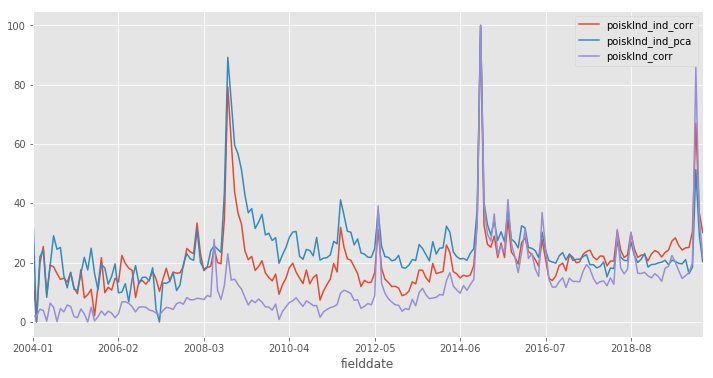

In [11]:
df_pi['poiskInd_ind_corr'] = index_poisk
df_pi.set_index('fielddate').plot(legend=True, figsize=(12,6));

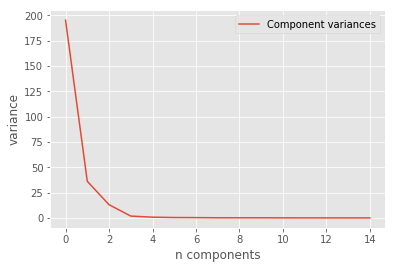

In [12]:
from sklearn.decomposition import PCA
model_pca = PCA(n_components= 15)
model_pca.fit(df_poisk)
df_pi_pca = model_pca.transform(df_poisk)

plt.plot(model_pca.explained_variance_, label='Component variances')
plt.xlabel('n components')
plt.ylabel('variance')
plt.legend(loc='upper right');

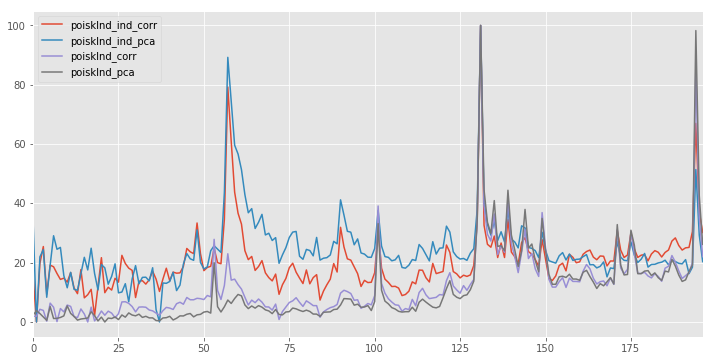

In [13]:
df_pi['poiskInd_ind_pca'] = list(df_pi_pca[:,1])
min_max_scaler(df_pi, 'poiskInd_ind_pca')

df_pi.plot(legend=True, figsize=(12,6));

--------

In [16]:
df_pi.to_csv('../Индексы/data_simple_index_v2/poisk_krizis_index_month.tsv', sep="\t", index=None)

-------------